In [1]:
import pandas as pd
from pathlib import Path

a2_df_census_ol_pejeta_western = pd.read_pickle("../data/pkl/a2_df_census_ol_pejeta_western.pkl")
a2_df_census_ol_pejeta_western_rank = pd.read_pickle("../data/pkl/a2_df_census_ol_pejeta_western_rank.pkl")
a2_df_census_ol_pejeta_western_rank.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Baboon troop,16,14,14,15,18,15,15,14,16,15,15,14,14,18,16,18,9
Black rhino,16,14,13,12,11,12,12,12,12,12,11,12,12,11,11,10,10
Buffalo,8,5,5,5,4,5,4,3,3,2,3,3,2,1,1,2,3
Bushbuck,16,14,18,17,18,18,19,22,19,16,19,21,16,20,16,18,17
Cattle,16,14,18,17,14,18,19,22,19,17,19,21,16,20,16,18,17


In [2]:
import pandas as pd
import numpy as np

summary = a2_df_census_ol_pejeta_western.copy()

to_rank = (
    summary
    .drop(index="Column_Total", errors="ignore")
    .drop(columns=["Row_Total"], errors="ignore")
)

ranks_wide = to_rank.rank(axis=0, method='min', ascending=False)

# 1) Reciprocal-rank weights (higher rank -> smaller weight)
recip = (1 / ranks_wide).astype(float).fillna(0)

# 2) Normalize within each year so column weights sum to 1 (makes years comparable)
recip_norm = recip.div(recip.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)

# 3) A cross-year dominance score per species (equal weight to each year)
species_recip_score = recip_norm.mean(axis=1).sort_values(ascending=False)

# Optional: “Borda-like” linear rank weights, also normalised per year
max_rank_per_year = ranks_wide.max(skipna=True)
borda = (max_rank_per_year - ranks_wide + 1)  # top rank gets largest weight
borda_norm = borda.div(borda.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
species_borda_score = borda_norm.mean(axis=1).sort_values(ascending=False)

borda.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Baboon troop,1.0,1.0,5.0,3.0,7.0,4.0,5.0,9.0,4.0,3.0,5.0,8.0,3.0,3.0,1.0,1.0,9.0
Black rhino,1.0,1.0,6.0,6.0,14.0,7.0,8.0,11.0,8.0,6.0,9.0,10.0,5.0,10.0,6.0,9.0,8.0
Buffalo,9.0,10.0,14.0,13.0,21.0,14.0,16.0,20.0,17.0,16.0,17.0,19.0,15.0,20.0,16.0,17.0,15.0
Bushbuck,1.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Cattle,1.0,1.0,1.0,1.0,11.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
species_borda_score.head(50)

Species
Plains zebra            0.095619
Impala                  0.090410
Buffalo                 0.083205
Thomson's gazelle       0.081633
Grant's gazelle         0.077763
Elephant                0.063471
Eland                   0.061641
Giraffe                 0.058727
Warthog                 0.053936
Hartebeest              0.048204
Waterbuck               0.044369
Black rhino             0.036648
Lion                    0.025979
Baboon troop            0.021006
Jackal                  0.018144
Hybrid zebra            0.017390
Grevy's zebra           0.015921
Southern white rhino    0.014525
Steenbok                0.013938
Hyena                   0.010064
Oryx                    0.009823
Patas monkey            0.008942
Cheetah                 0.007660
Cattle                  0.007345
Wild dog                0.007222
Bushbuck                0.006950
Hippo                   0.006840
Reedbuck                0.006838
Gerenuk                 0.005789
dtype: float64

In [4]:
# Proportional abundances per year
prop = to_rank.div(to_rank.sum(axis=0).replace(0, np.nan), axis=1)

# Shannon diversity H' and Pielou evenness J' per year
H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0)
S = (to_rank > 0).sum(axis=0)                    # richness
J = H / np.log(S.replace(0, np.nan))

# Bray–Curtis dissimilarity needs pairwise comparisons; Spearman rank corr for rank stability:
spearman_by_year = to_rank.corr(method='spearman')  # columns = years
prop.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Baboon troop,0.000000,0.000000,0.000494,0.000168,0.000306,0.000451,0.000305,0.000645,0.000310,0.001139,0.000147,0.000518,0.000339,0.000260,0.000000,0.000000,0.016889
Black rhino,0.000000,0.000000,0.001318,0.001006,0.003824,0.002859,0.002033,0.003615,0.003567,0.003904,0.004560,0.003626,0.001016,0.005323,0.003096,0.010097,0.009427
Buffalo,0.011347,0.062268,0.052866,0.081140,0.113355,0.034612,0.080089,0.148206,0.133065,0.219457,0.197852,0.222069,0.275375,0.254869,0.350880,0.227319,0.151021
Bushbuck,0.000000,0.000000,0.000000,0.000000,0.000306,0.000000,0.000000,0.000000,0.000000,0.000163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cattle,0.000000,0.000000,0.000000,0.000000,0.000765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
abund = a2_df_census_ol_pejeta_western

In [6]:
def diversity_metrics(abund: pd.DataFrame) -> pd.DataFrame:
    # proportions per year
    col_sums = abund.sum(axis=0)
    prop = abund.div(col_sums.replace(0, np.nan), axis=1)

    # richness (Hill N0)
    S = (abund > 0).sum(axis=0)

    # Shannon (H'), Hill N1 = exp(H')
    H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0).fillna(0)
    N1 = np.exp(H)

    # Simpson D = sum p^2, Hill N2 = 1/D
    D = (prop ** 2).sum(axis=0).fillna(0)
    N2 = (1 / D.replace(0, np.nan)).fillna(0)

    # Evenness: Pielou J' and Hill evenness (N1/S)
    J = (H / np.log(S.replace(0, np.nan))).fillna(0)
    E_hill = (N1 / S.replace(0, np.nan)).fillna(0)

    out = pd.DataFrame({
        "Richness_S": S,
        "Shannon_H'": H,
        "Hill_N1": N1,
        "Simpson_D": D,
        "Hill_N2": N2,
        "Pielou_J'": J,
        "Hill_evenness_N1_over_S": E_hill,
        "Total_Abundance": col_sums
    })
    out.index.name = "Year"
    return out

metrics = diversity_metrics(abund)
metrics.round(3).head(50)

,Richness_S,Shannon_H',Hill_N1,Simpson_D,Hill_N2,Pielou_J',Hill_evenness_N1_over_S,Total_Abundance
Year,,,,,,,,
2005,16,1.363,3.908,0.356,2.808,0.492,0.244,10752
2006,14,1.474,4.367,0.337,2.965,0.559,0.312,9154
2007,18,1.469,4.344,0.335,2.983,0.508,0.241,12144
2008,17,1.524,4.591,0.315,3.173,0.538,0.270,11930
2009,24,1.644,5.177,0.300,3.331,0.517,0.216,13074
2010,18,1.501,4.487,0.328,3.047,0.519,0.249,13290
2012,19,1.578,4.847,0.310,3.227,0.536,0.255,19678
2013,22,1.628,5.094,0.302,3.307,0.527,0.232,15492
2014,19,1.652,5.218,0.301,3.324,0.561,0.275,12896


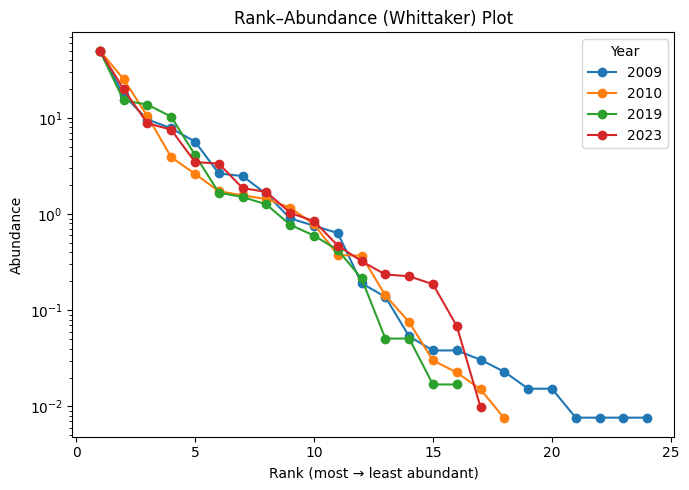

In [7]:
import matplotlib.pyplot as plt

def whittaker_plot(abund: pd.DataFrame, years=None, log_y=True):
    """
    Draws rank–abundance curves. One curve per year.
    """
    if years is None:
        years = list(abund.columns)

    plt.figure(figsize=(7, 5))
    for yr in years:
        s = abund[yr]
        s = s[s > 0].sort_values(ascending=False)  # positive abundances only
        if s.empty:
            continue
        ranks = np.arange(1, len(s) + 1)
        plt.plot(ranks, s.values, marker="o", label=str(yr))

    plt.xlabel("Rank (most → least abundant)")
    plt.ylabel("Abundance")
    if log_y:
        plt.yscale("log")  # classic Whittaker uses log-abundance
    plt.title("Rank–Abundance (Whittaker) Plot")
    plt.legend(title="Year")
    plt.tight_layout()
    plt.show()

# Example: plot a few years (or omit 'years=' to plot all)
#whittaker_plot(abund, years=[2005, 2009, 2017, 2023], log_y=True)
#whittaker_plot(prop*100, years=[2009, 2023], log_y=False)
#whittaker_plot(abund, years=[2008, 2019], log_y=True)
#whittaker_plot(abund, years=[2009, 2010, 2019, 2023], log_y=True)
prop = abund.div(abund.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
whittaker_plot(prop*100, years=[2009, 2010, 2019, 2023], log_y=True)